#### Setup

In [ ]:
%pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow keras

#### Imports

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#### Load Data

In [9]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')


#### Data Cleaning

In [10]:
train = train.drop('Id', axis = 1)
ids = test.pop('Id')

In [11]:
print(train.columns)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [12]:
missing_counts = train.isnull().sum()
columns_with_missing = missing_counts[missing_counts > 0].index
print(columns_with_missing)

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


In [13]:
def handle_null_na (data):
    data['LotFrontage'] = data['LotFrontage'].fillna(0)
    data['Alley'] = data['Alley'].fillna('NA')
    data['MasVnrArea'] = data['MasVnrArea'].fillna(0)
    data['MasVnrType'] = data['MasVnrType'].fillna('None')
    data['BsmtQual'] = data['BsmtQual'].fillna('NA')
    data['BsmtCond'] = data['BsmtCond'].fillna('NA')
    data['BsmtExposure'] = data['BsmtExposure'].fillna('NA')
    data['BsmtFinType1'] = data['BsmtFinType1'].fillna('NA')
    data['BsmtFinType2'] = data['BsmtFinType2'].fillna('NA')
    data['Electrical'] = data['Electrical'].fillna('SBrkr')
    data['FireplaceQu'] = data['FireplaceQu'].fillna('NA')
    data['GarageType'] = data['GarageType'].fillna('NA')
    data['GarageYrBlt'] = data['GarageYrBlt'].fillna(-1)
    data['GarageFinish'] = data['GarageFinish'].fillna('NA')
    data['GarageQual'] = data['GarageQual'].fillna('NA')
    data['GarageCond'] = data['GarageCond'].fillna('NA')
    data['PoolQC'] = data['PoolQC'].fillna('NA')
    data['Fence'] = data['Fence'].fillna('NA')
    data['MiscFeature'] = data['MiscFeature'].fillna('NA')
    return data

train = handle_null_na(train)
test = handle_null_na(test)


Null/NA value fill Reasons:
Most of the missing values appeared to be because of mishandled NA or none qualifiers so I just manually filled missing with strings, additionally if a house didn't have a feature its area was left as NA and I chose to just make it 0 since area of 0 doesn't exist, or a year of -1.

#### Feature Engineering

In [14]:
def add_features(data):
    data['HouseAge'] = data['YrSold'] - data['YearBuilt']
    data['RemodAge'] = data.apply(lambda row: row['YrSold'] - row['YearRemodAdd'] if row['YearRemodAdd'] != 0 else 0, axis=1)
    data['GarageAge'] = data.apply(lambda row: row['YrSold'] - row['GarageYrBlt'] if row['GarageYrBlt'] != 0 else 0, axis=1)
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

    return data

train = add_features(train)
test = add_features(test)

#### Data Preprocessing

In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
def preprocess(dataframe, cat_columns, num_columns):
    encoder = OneHotEncoder(sparse_output = False,
                            handle_unknown = 'ignore')
    scaler = StandardScaler()

    #encode categorical columns
    encoded_cols = encoder.fit_transform(dataframe[cat_columns])
    encoded_df = pd.DataFrame(encoded_cols, columns = encoder.get_feature_names_out(cat_columns))
    dataframe = pd.concat([dataframe.reset_index(drop = True), encoded_df.reset_index(drop = True)], axis = 1)

    #scale numerical columns
    scaled_cols = scaler.fit_transform(dataframe[num_columns])
    scaled_df = pd.DataFrame(scaled_cols, columns = num_columns)
    dataframe = pd.concat([dataframe.reset_index(drop = True), scaled_df.reset_index(drop = True)], axis = 1)

    #drop original columns
    dataframe.drop(columns = cat_columns + num_columns, inplace = True)
    return dataframe

cat_cols = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
            'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st',
            'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
            'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
            'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
            'MoSold', 'YrSold', 'SaleCondition']
num_cols = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
            '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
            'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
            'PoolArea', 'MiscVal', 'GarageYrBlt', 'HouseAge', 'RemodAge', 'GarageAge', 'TotalSF']

processed_train = preprocess(train, cat_cols, num_cols)
processed_test = preprocess(test, cat_cols, num_cols)



In [16]:
missing_cols = set(processed_test.columns) - set(processed_train.columns)
print(missing_cols)
print(len(missing_cols))

{'GarageCars_4.0', 'GarageCars_0.0', 'GarageCars_nan', 'GarageCars_3.0', 'GarageCars_2.0', 'Exterior1st_nan', 'Functional_nan', 'GarageCars_5.0', 'SaleType_nan', 'MSZoning_nan', 'GarageCars_1.0', 'Exterior2nd_nan', 'KitchenQual_nan', 'MSSubClass_150', 'Utilities_nan'}
15


In [17]:
for col in missing_cols:
    processed_train[col] = 0

missing_cols = set(processed_test.columns) - set(processed_train.columns)
print(len(missing_cols))

0


#### Modeling

In [18]:
from sklearn.model_selection import train_test_split
#create train test split for model
X = processed_train.drop(columns = 'SalePrice')
y = processed_train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)

train_tensor = tf.convert_to_tensor(X_train, dtype = tf.float32)
valid_tensor = tf.convert_to_tensor(X_valid, dtype = tf.float32)

train_labels = tf.convert_to_tensor(y_train, dtype = tf.float32)
valid_labels = tf.convert_to_tensor(y_valid, dtype = tf.float32)

In [39]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from kerastuner import HyperModel
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.metrics import RootMeanSquaredError

class HousePriceHyperModel(HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Input(shape=(X_train.shape[1],)))
        model.add(layers.BatchNormalization())

        for i in range(hp.Int('num_layers', 1, 3)):
            units = hp.Int('units_' + str(i), 
                           min_value=32,
                           max_value=128,
                           step=32)
            activation = 'relu'
            
            # Add regularization
            kernel_regularizer = regularizers.l2(hp.Float('l2_regularization_' + str(i), 
                                                          min_value=1e-6, 
                                                          max_value=1e-3, 
                                                          sampling='LOG'))

            model.add(layers.Dense(units=units,
                                   activation=activation,
                                   kernel_regularizer=kernel_regularizer))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(hp.Float('dropout_' + str(i),
                                              min_value=0.3,
                                              max_value=0.7,
                                              step=0.1)))
        model.add(layers.Dense(1, activation='linear'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=hp.Float('learning_rate', 
                                       min_value=1e-6,
                                       max_value=1e-3,
                                       sampling='LOG')
            ),
            loss='mse',
            metrics=['mean_absolute_error', RootMeanSquaredError()]
        )
        return model
    
tuner = BayesianOptimization(
    HousePriceHyperModel(),
    objective = 'val_mean_absolute_error',
    max_trials = 25,
    directory = 'House Price Tuning',
    project_name = 'House Price Prediction',
    overwrite = True
)

#********************#
MY_PATIENCE = 5
MY_EPOCHS = 250
MY_MIN_DELTA = 0.01
#********************#

tuner.search(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=MY_EPOCHS,
    callbacks=[keras.callbacks.EarlyStopping(patience=MY_PATIENCE, min_delta=MY_MIN_DELTA, restore_best_weights=True)]
)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', RootMeanSquaredError()])
best_model.evaluate(X_valid, y_valid)

Trial 3 Complete [00h 00m 34s]
val_mean_absolute_error: 182729.109375

Best val_mean_absolute_error So Far: 182729.109375
Total elapsed time: 00h 01m 22s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
1                 |2                 |num_layers
128               |96                |units_0
5.4882e-05        |4.1886e-06        |l2_regularization_0
0.6               |0.5               |dropout_0
1.6373e-05        |0.00042489        |learning_rate
128               |96                |units_1
5.5886e-06        |8.6159e-05        |l2_regularization_1
0.3               |0.3               |dropout_1
128               |32                |units_2
3.8687e-05        |1.4744e-05        |l2_regularization_2
0.5               |0.6               |dropout_2

Epoch 1/250


#### Plots of model info

Epoch 1/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5563510784.0000 - mean_squared_error: 5563510784.0000 - root_mean_squared_error: 74443.0000 - val_loss: 7280494592.0000 - val_mean_squared_error: 7280494592.0000 - val_root_mean_squared_error: 85325.8125
Epoch 2/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6110077440.0000 - mean_squared_error: 6110077440.0000 - root_mean_squared_error: 78127.0156 - val_loss: 7640334336.0000 - val_mean_squared_error: 7640334336.0000 - val_root_mean_squared_error: 87409.0078
Epoch 3/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5555718144.0000 - mean_squared_error: 5555718144.0000 - root_mean_squared_error: 74460.7812 - val_loss: 7654963712.0000 - val_mean_squared_error: 7654963712.0000 - val_root_mean_squared_error: 87492.6484
Epoch 4/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6225561088.0000 - mean_squared_error: 6225561088.0000 - root_mean_squared_error: 78811.4531 - val_loss: 8026676224.0000 - val_mean_squared_error: 802667

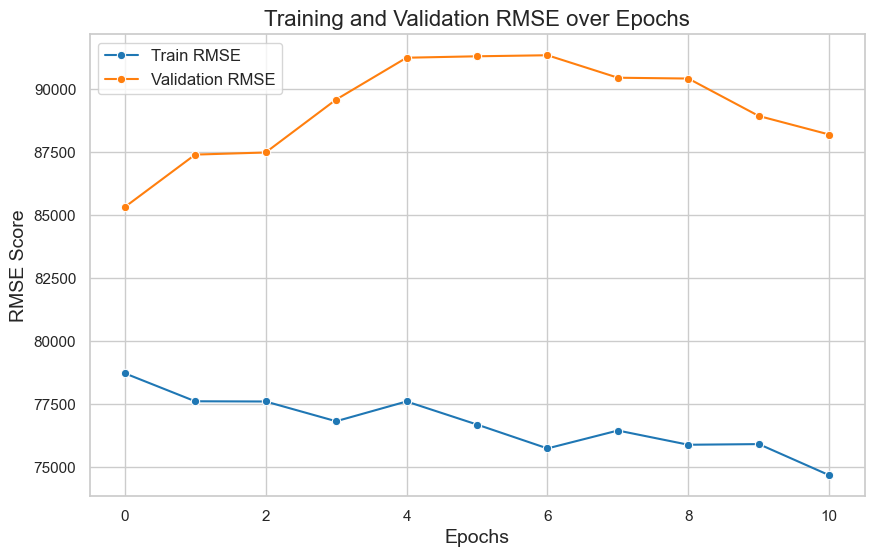

In [30]:
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=MY_EPOCHS,
    callbacks=[keras.callbacks.EarlyStopping(patience=MY_PATIENCE, min_delta=MY_MIN_DELTA, restore_best_weights=True)]
)


sns.set_style('whitegrid')
sns.set_context('notebook')

plt.figure(figsize=(10, 6))
sns.lineplot(data=history.history['root_mean_squared_error'], label='Train RMSE', marker='o')
sns.lineplot(data=history.history['val_root_mean_squared_error'], label='Validation RMSE', marker='o')


plt.xlabel('Epochs', fontsize=14)
plt.ylabel('RMSE Score', fontsize=14)
plt.title('Training and Validation RMSE over Epochs', fontsize=16)
plt.legend(fontsize=12)
plt.show()

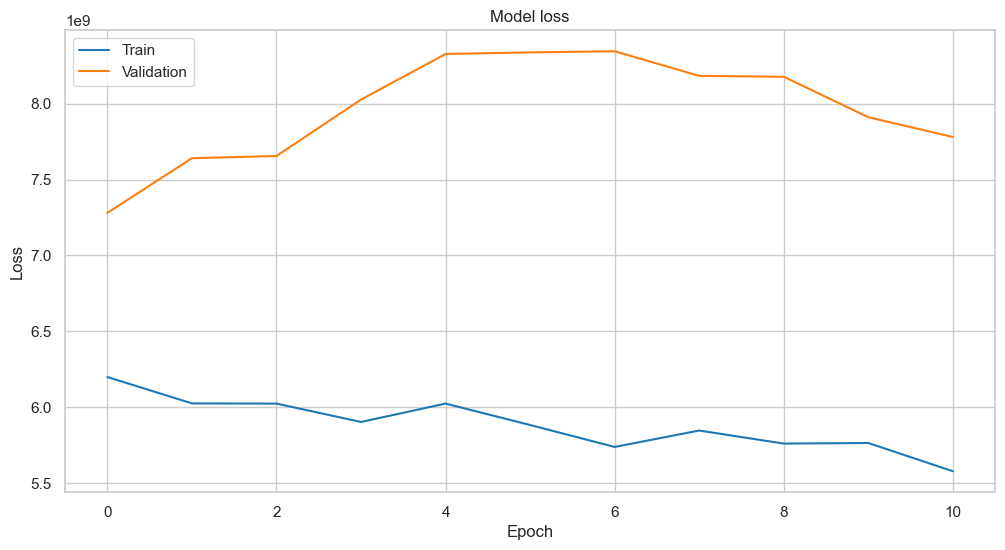

In [31]:
#Plot Training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

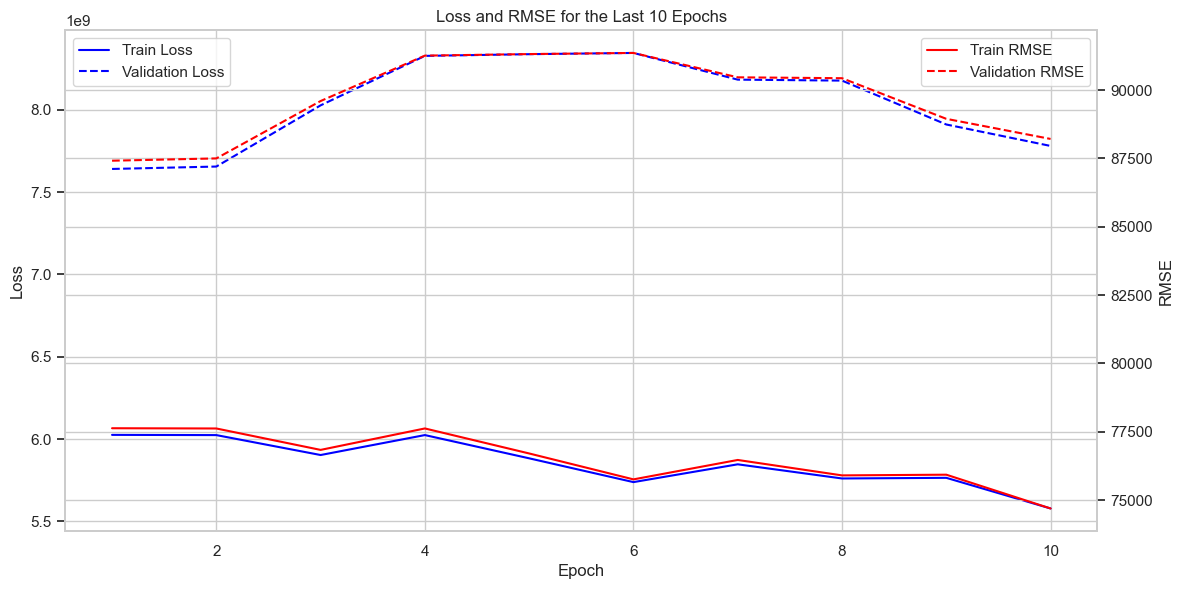

In [36]:
#last 10 epochs
last_10_epochs = range(len(history.history['loss']) - 10, len(history.history['loss']))
last_10_train_loss = history.history['loss'][-10:]
last_10_val_loss = history.history['val_loss'][-10:]
last_10_train_rmse = history.history['root_mean_squared_error'][-10:]
last_10_val_rmse = history.history['val_root_mean_squared_error'][-10:]

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(last_10_epochs, last_10_train_loss, 'b-', label='Train Loss')
ax1.plot(last_10_epochs, last_10_val_loss, 'b--', label='Validation Loss')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# Creating a second y-axis for RMSE
ax2 = ax1.twinx()
ax2.set_ylabel('RMSE')
ax2.plot(last_10_epochs, last_10_train_rmse, 'r-', label='Train RMSE')
ax2.plot(last_10_epochs, last_10_val_rmse, 'r--', label='Validation RMSE')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Loss and RMSE for the Last 10 Epochs')
plt.show()

In [ ]:
#fitted line

#### Output Predictions

In [26]:
# Verify the shape of X_train and test
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of test: {processed_test.shape}")

missing_features = set(X_train.columns) - set(processed_test.columns)
print(f"Missing features: {missing_features}")

for features in missing_features:
    processed_test[features] = 0

Shape of X_train: (1168, 337)
Shape of test: (1459, 314)
Missing features: {'Exterior1st_ImStucc', 'RoofMatl_Membran', 'GarageCars_0', 'MiscFeature_TenC', 'Condition2_RRAe', 'RoofMatl_ClyTile', 'PoolQC_Fa', 'GarageCars_1', 'Electrical_Mix', 'RoofMatl_Metal', 'Condition2_RRAn', 'Exterior1st_Stone', 'Heating_OthW', 'GarageCars_2', 'GarageCars_3', 'GarageQual_Ex', 'RoofMatl_Roll', 'HouseStyle_2.5Fin', 'Condition2_RRNn', 'Heating_Floor', 'Utilities_NoSeWa', 'Exterior2nd_Other', 'GarageCars_4'}


In [27]:
predictions = best_model.predict(processed_test)

predictions = predictions.flatten()
output_df = pd.DataFrame({'Id': ids, 'SalePrice': predictions})
output_df.to_csv('NN_predictions.csv', index=False)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
